In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import embedders

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

N_TRIALS = 100
MAX_DEPTH = 5
SPECIAL_DIMS = False

pm = embedders.manifolds.ProductManifold(
    # signature=[(-1, 2)], (0, 2), (1, 2)]
    signature=[(2, 2)]
)

def roc_curve_uniform(y_true, probs):
    thresholds = np.linspace(0, 1.01, 101)
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred = (probs[:, 1] > threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return fpr, tpr#, thresholds

# results = np.zeros((100, 2))
fprs_dt = np.zeros((N_TRIALS, 101))
tprs_dt = np.zeros((N_TRIALS, 101))
fprs_pdt = np.zeros((N_TRIALS, 101))
tprs_pdt = np.zeros((N_TRIALS, 101))
aucs_dt = np.zeros(N_TRIALS)
aucs_pdt = np.zeros(N_TRIALS)
for i in range(N_TRIALS):
    X, y = embedders.gaussian_mixture.gaussian_mixture(
        pm, cov_scale_points=1.0, cov_scale_means=0.1
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    dt = DecisionTreeClassifier(max_depth=MAX_DEPTH)
    dt.fit(X_train, y_train)
    dt_probs = dt.predict_proba(X_test)

    pdt = embedders.tree_new.ProductSpaceDT(pm, max_depth=MAX_DEPTH, use_special_dims=SPECIAL_DIMS)
    pdt.fit(X_train, y_train)
    pdt_probs = pdt.predict_proba(X_test).detach().numpy()

    # Soften probabilities to deal with discrete outputs
    dt_probs = dt_probs + 1e-6
    dt_probs = dt_probs / np.sum(dt_probs, axis=1)[:, np.newaxis]
    pdt_probs = pdt_probs + 1e-6
    pdt_probs = pdt_probs / np.sum(pdt_probs, axis=1)[:, np.newaxis]

    # Get whole roc curve
    # fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_probs[:, 1])
    # fpr_pdt, tpr_pdt, threshdolds_pdt = roc_curve(y_test, pdt_probs[:, 1])
    fpr_dt, tpr_dt = roc_curve_uniform(y_test.numpy(), dt_probs)
    fpr_pdt, tpr_pdt = roc_curve_uniform(y_test.numpy(), pdt_probs)

    fprs_dt[i] = fpr_dt
    tprs_dt[i] = tpr_dt
    fprs_pdt[i] = fpr_pdt
    tprs_pdt[i] = tpr_pdt

    # Get AUCs as well
    aucs_dt[i] = auc(fpr_dt, tpr_dt)
    aucs_pdt[i] = auc(fpr_pdt, tpr_pdt)

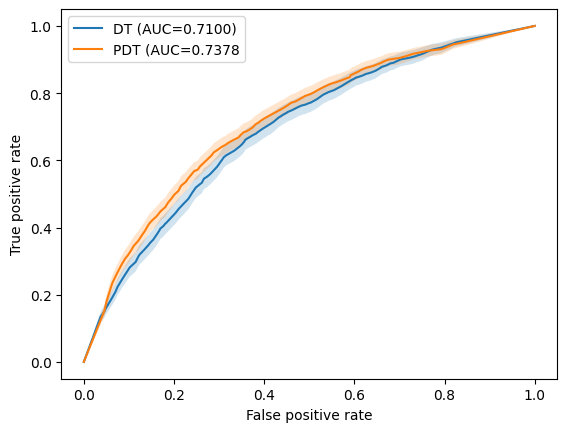

In [112]:
# Plots

plt.plot(
    fprs_dt.mean(axis=0), tprs_dt.mean(axis=0), label=f"DT (AUC={aucs_dt.mean():.4f})"
)
plt.fill_between(
    fprs_dt.mean(axis=0),
    tprs_dt.mean(axis=0) - tprs_dt.std(axis=0) / np.sqrt(N_TRIALS),
    tprs_dt.mean(axis=0) + tprs_dt.std(axis=0) / np.sqrt(N_TRIALS),
    alpha=0.2
)
plt.plot(
    fprs_pdt.mean(axis=0), tprs_pdt.mean(axis=0), label=f"PDT (AUC={aucs_pdt.mean():.4f}"
)
plt.fill_between(
    fprs_pdt.mean(axis=0),
    tprs_pdt.mean(axis=0) - tprs_pdt.std(axis=0) / np.sqrt(N_TRIALS),
    tprs_pdt.mean(axis=0) + tprs_pdt.std(axis=0) / np.sqrt(N_TRIALS),
    alpha=0.2
)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()